# 데이터 로더

* [데이터 로더 구현](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)
* batch 기반의 딥러닝 모델 학습을 위해 데이터를 효율적으로 읽어오는 역할

```
    def __init__(self, x_set, y_set, batch_size): # 생성자(속성을 정의)
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self): # 학습되고있는 배치로 나뉘어져있는 갯수를 리턴시켜줌
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx): # 1개월차 16.스페셜메소드 참조
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)
```

In [14]:
!pip install tensorflow-cpu

In [15]:
from tensorflow import keras
import pandas as pd
import numpy as np

In [16]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train',shuffle=True):
        self.batch_size = batch_size
        self.csv_path = csv_path
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self. shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
            
        self.on_epoch_end()
        
    
    # frac : 전체 row에서 몇 %의 데이터를 return할 것인지를 설정
    # frac = 1 -> 100%라는 이야기
    # reset_index(drop = True) : 인덱스를 없애겠다
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac = 1).reset_index(drop = True)
            
            
    
    # df의 전체 갯수를 self.batch_size로 나눠서 ceil하면 올림해서 return 시켜줌
    def __len__(self): # 학습되고있는 배치로 나뉘어져있는 갯수를 리턴시켜줌
        return math.ceil(len(self.df) / self.batch_size)
    
    
    # 객체를 만들고 그것을 인덱싱해서 접근하면 호출하는 것
    def __getitem__(self, idx):
        start = idx * self.batch_size # 만약 idx에 0번을 넣으면 0부터 시작, 1번이면 1* self.batch_size이다
        end = (idx + 1) * self.batch_size
        data = self.df.iloc[start:end] # 만약 0부터 64미만이라면
        batch_x, batch_y = self.get_data(data) # 리턴되는 값이 두개가 나옴
        return np.array(batch_x), np.array(batch_y)
    
    
    def get_data(self, data):
        batch_x = []
        batch_y = [] # self가 안붙었으니 이 batch_x,y는 이 메소드 안에서만 사용한다.
        
        for _, r in data.iterrows(): # data에서 넘어오는 리스트가 인덱스번호(_)는 안쓰고, 데이터(r)는 쓴다
            file_name = r['file_name']
            image = cv2.imread(f'C:/python/Jupyter/jupyter/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size)) # 이미지 크기가 다 제각각이므로 다 동일하게 맞춤
            iamge = image/ 255. # 나눠준 이유는 정규화하기 위해(나중에 cnn모델 쓸때 색상정보는 기울기로 쓰이는데 숫자가 낮아지면 속도가 빨라지니까)
            
            label = int(r['species']) - 1 # soecies보면 1로 되어있는데 9부터 시작하기위해 -1을 해준다
            
            batch_x.append(image) # 계속 쌓아줌
            batch_y.append(label)
            
        return batch_x, batch_y

In [17]:
import math
import cv2
import matplotlib.pyplot as plt

In [21]:
csv_path = 'C:\python\Jupyter\jupyter/kfolds.csv'

train_generator = DataGenerator(
    batch_size = 9,
    csv_path = csv_path,
    fold = 1, # train이니까 1번을 제외하고 다 학습시킨다
    image_size = 256,
    mode = 'train',
    shuffle = True
)

In [22]:
print(len(train_generator))

654


In [23]:
654 * 9 # len(train_generator)의 갯수 * batch_size

5886

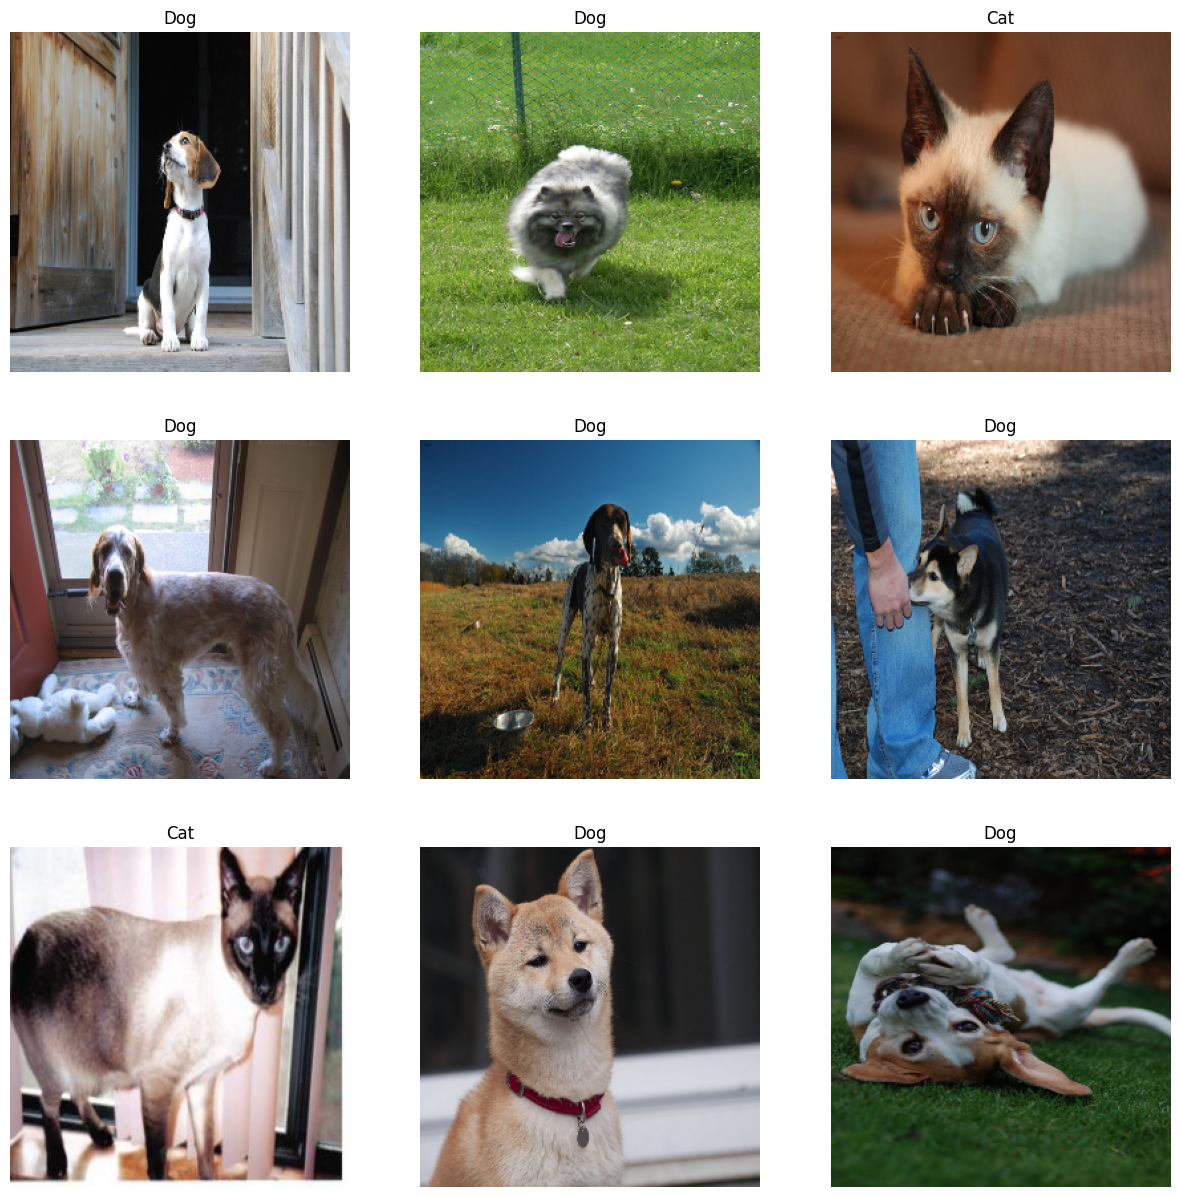

In [24]:
class_name = ['Cat','Dog']

for batch in train_generator:
    X, y = batch # X는 이미지, y는 라벨
    plt.figure(figsize=(15,15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
    break